# Task 1: Denoising Autoencoder

Install dependencies

In [ ]:
 # !pip install -r requirements.txt

## Model Setup
For a denoising autoencoder with 4 encoding/decoding layers, we'll define a simple architecture using TensorFlow's Keras API. The model will take 64x64 grayscale images, add noise, and learn to reconstruct the original images.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Check if CUDA is available and set device to GPU if it is.
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Define the Autoencoder Architecture
class DenoisingAutoencoder(tf.keras.Model):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Conv2D(16, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(64, 3, strides=2, padding='same', activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Prepare Data
Since you mentioned using natural grayscale images of size 64x64, for demonstration purposes, let's assume you have these images stored in a directory. PyTorch's DataLoader will be used to handle these images.

In [2]:
class SyntheticDataset(tf.keras.utils.Sequence):
    def __init__(self, num_images=100, image_size=(64, 64), noise_type='uniform'):
        self.num_images = num_images
        self.image_size = image_size
        self.noise_type = noise_type
        self.data = self.generate_dataset()

    def generate_dataset(self):
        data = []
        for _ in range(self.num_images):
            image = np.random.rand(*self.image_size).astype(np.float32)
            noisy_image = self.add_noise(image)
            data.append((noisy_image, image))
        return data

    def add_noise(self, image):
        if self.noise_type == 'uniform':
            noise = np.random.uniform(low=-0.5, high=0.5, size=self.image_size).astype(np.float32)
        elif self.noise_type == 'gaussian':
            noise = np.random.normal(loc=0.0, scale=0.5, size=self.image_size).astype(np.float32)
        noisy_image = image + noise
        return np.clip(noisy_image, 0, 1)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        noisy_image, clean_image = self.data[idx]
        # Delete extra dim
        return noisy_image.squeeze()[..., np.newaxis], clean_image.squeeze()[..., np.newaxis]

# Dataset
train_dataset = SyntheticDataset(num_images=100, image_size=(64, 64), noise_type='uniform')
val_dataset = SyntheticDataset(num_images=30, image_size=(64, 64), noise_type='gaussian')
test_dataset = SyntheticDataset(num_images=30, image_size=(64, 64), noise_type='gaussian')

# tf.data.Dataset
def create_tf_dataset(dataset, batch_size):
    return tf.data.Dataset.from_generator(
        lambda: dataset,
        output_signature=(
            tf.TensorSpec(shape=(64, 64, 1), dtype=tf.float32),
            tf.TensorSpec(shape=(64, 64, 1), dtype=tf.float32)
        )
    ).batch(batch_size)

train_ds = create_tf_dataset(train_dataset, batch_size=10)
val_ds = create_tf_dataset(val_dataset, batch_size=10)
test_ds = create_tf_dataset(test_dataset, batch_size=10)

### Sample of the image

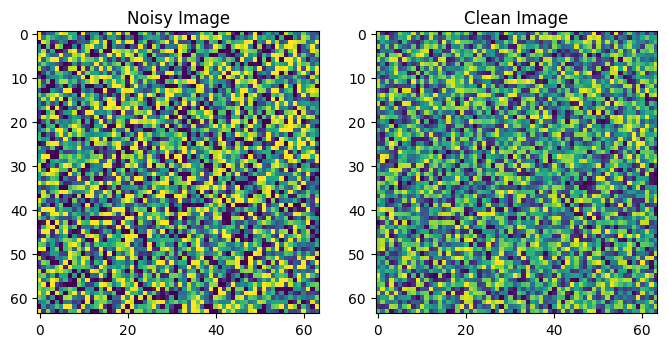

In [3]:
# Show a sample
sample_noisy, sample_clean = train_dataset[0]
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy Image")
plt.imshow(sample_noisy[:, :, 0])
plt.subplot(1, 2, 2)
plt.title("Clean Image")
plt.imshow(sample_clean[:, :, 0])
plt.show()

## Train the Autoencoder
Add noise to the images during training and evaluate using clean images.

In [4]:
# loss function
criterion = tf.keras.losses.MeanSquaredError()

# train fuction
def train(model, train_ds, val_ds, optimizer, criterion, lr, epochs=200, patience=15, sch_decrease_rate=0.1, save_path='./tf_best_model/best_model'):
    best_loss = float('inf')
    epochs_no_improve = 0
    
    # Inicializar el planificador de tasa de aprendizaje
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=lr,
        decay_steps=epochs,
        alpha=sch_decrease_rate
    )
    optimizer.learning_rate = lr_schedule

    for epoch in range(epochs):
        # Train
        train_loss = tf.keras.metrics.Mean()
        for noisy_imgs, clean_imgs in train_ds:
            with tf.GradientTape() as tape:
                outputs = model(noisy_imgs, training=True)
                loss = criterion(clean_imgs, outputs)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            train_loss.update_state(loss)
        
        # Val
        val_loss = tf.keras.metrics.Mean()
        for noisy_imgs, clean_imgs in val_ds:
            outputs = model(noisy_imgs, training=False)
            val_loss.update_state(criterion(clean_imgs, outputs))
        
        current_lr = lr_schedule(optimizer.iterations)
        print(f'Epoch {epoch+1}, Training Loss: {train_loss.result():.4f}, Validation Loss: {val_loss.result():.4f}, Current LR: {current_lr:.6f}')
        
        # Early stopping
        if val_loss.result() < best_loss:
            best_loss = val_loss.result()
            epochs_no_improve = 0
            print(f"New best validation loss: {val_loss.result()}. Saving model...")
            model.save_weights(save_path)
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {epoch + 1} epochs.')
                break
    
    return model

In [5]:
# Initialize the model and optimizer
model = DenoisingAutoencoder()
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Compile model
model.compile(optimizer=optimizer, loss=criterion)

# Start training
trained_model = train(model, train_ds, val_ds, optimizer, criterion, lr=lr, epochs=500, patience=50)

Epoch 1, Training Loss: 0.0833, Validation Loss: 0.0831, Current LR: 0.000999
New best validation loss: 0.08309752494096756. Saving model...
Epoch 2, Training Loss: 0.0832, Validation Loss: 0.0830, Current LR: 0.000996
New best validation loss: 0.08304092288017273. Saving model...
Epoch 3, Training Loss: 0.0831, Validation Loss: 0.0829, Current LR: 0.000992
New best validation loss: 0.08288335800170898. Saving model...
Epoch 4, Training Loss: 0.0826, Validation Loss: 0.0824, Current LR: 0.000986
New best validation loss: 0.08243726193904877. Saving model...
Epoch 5, Training Loss: 0.0816, Validation Loss: 0.0818, Current LR: 0.000978
New best validation loss: 0.08181840181350708. Saving model...
Epoch 6, Training Loss: 0.0803, Validation Loss: 0.0819, Current LR: 0.000968
Epoch 7, Training Loss: 0.0794, Validation Loss: 0.0814, Current LR: 0.000957
New best validation loss: 0.08143490552902222. Saving model...
Epoch 8, Training Loss: 0.0786, Validation Loss: 0.0812, Current LR: 0.00094

## Evaluate the Model
Test the autoencoder's performance on the test set with Gaussian noise.

In [6]:
# Evaluate the model
def evaluate(model, dataset):
    loss_metric = tf.keras.metrics.Mean()
    for noisy_imgs, clean_imgs in dataset:
        outputs = model(noisy_imgs, training=False)
        loss = criterion(clean_imgs, outputs)
        loss_metric.update_state(loss)
    print(f'Average Loss: {loss_metric.result():.4f}')
    return loss_metric.result()

In [7]:
_model = DenoisingAutoencoder()
_model.build((None, 64, 64, 1))  # build the model with a correct input shape
_model.load_weights("./tf_best_model/best_model")

# Evaluar en el conjunto de prueba
evaluate(_model, test_ds)

Average Loss: 0.0773


<tf.Tensor: shape=(), dtype=float32, numpy=0.07731778>

## Visualization
Finally, visualize the results to check how well the autoencoder is performing.

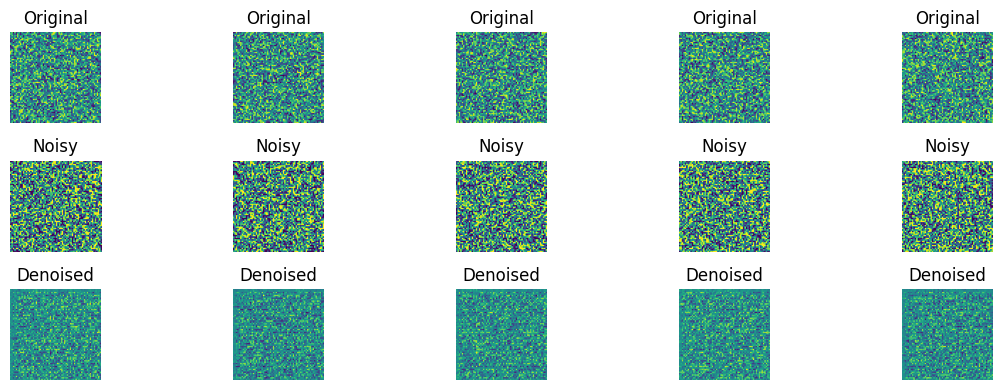

In [8]:
import matplotlib.pyplot as plt

def visualize_denoising(model, dataset):
    noisy_imgs, clean_imgs = next(iter(dataset))  # Obtener un lote de imágenes
    denoised_images = model(noisy_imgs)
    
    # Visualización
    plt.figure(figsize=(12, 4))
    for i in range(5):  # Mostrar 5 imágenes del lote
        plt.subplot(3, 5, i + 1)
        plt.imshow(clean_imgs[i, :, :, 0].numpy().squeeze())
        plt.title('Original')
        plt.axis('off')
        plt.subplot(3, 5, i + 1 + 5)
        plt.imshow(noisy_imgs[i, :, :, 0].numpy().squeeze())
        plt.title('Noisy')
        plt.axis('off')
        plt.subplot(3, 5, i + 1 + 10)
        plt.imshow(denoised_images[i, :, :, 0].numpy().squeeze())
        plt.title('Denoised')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming `model` and `dataloader` are already defined and initialized
visualize_denoising(_model, test_ds)


# Task 2: Image Order Identification

We need to develop a system where a sender, S, builds a binary message about the order of two concatenated images, and a receiver, R, uses the binary message and two augmented images in random order to determine their sequence. This task is more complex than the first one and involves image processing, model training, and augmentation techniques.

## Step 1: Import Libraries and Prepare the Environment
First, we'll import necessary libraries and set up the environment.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Configuración del dispositivo
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

### Load CIFAR10 data

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from random import randint
from sklearn.model_selection import train_test_split

# Define data augmentation function
def augment_image(image):
    # Ensure image is in the correct shape (H, W, C)
    if len(image.shape) != 3:
        raise ValueError(f"Expected image with 3 dimensions (H, W, C), but got {image.shape}")

    if randint(0, 1):
        image = tf.image.flip_left_right(image)
    if randint(0, 1):
        image = tf.image.rot90(image)
    # Add color jittering
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)
    # Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
    return image + noise

# Custom dataset for paired CIFAR10 images
class PairedCIFAR10Dataset(tf.data.Dataset):
    def __new__(cls, cifar10_dataset):
        def generator():
            for idx in range(len(cifar10_dataset) // 2):
                img1 = cifar10_dataset[idx * 2][0]  # Solo tomar la imagen
                img2 = cifar10_dataset[idx * 2 + 1][0]  # Solo tomar la imagen
                
                # Ensure images have the correct shape (H, W, C)
                if img1.shape[-1] != 3:
                    img1 = np.repeat(img1[:, :, np.newaxis], 3, axis=2)  # Add channel dimension if missing
                if img2.shape[-1] != 3:
                    img2 = np.repeat(img2[:, :, np.newaxis], 3, axis=2)  # Add channel dimension if missing
                
                # Convert images to tensors
                img1 = tf.convert_to_tensor(img1, dtype=tf.float32) / 255.0
                img2 = tf.convert_to_tensor(img2, dtype=tf.float32) / 255.0
                
                # Concatenate images
                x = tf.concat([img1, img2], axis=-1)
                
                # Create augmented versions
                x1_aug = augment_image(img1)
                x2_aug = augment_image(img2)
                
                yield x, x1_aug, x2_aug
        
        return tf.data.Dataset.from_generator(generator, output_signature=(
            tf.TensorSpec(shape=(32, 32, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(32, 32, 3), dtype=tf.float32)
        ))

# Set batch size
BATCH_SIZE = 16

# Load CIFAR-10 dataset
(cifar10_images, _), (test_cifar10_images, _) = tf.keras.datasets.cifar10.load_data()

# Split the dataset to get only 100 images for training and 30 for validation
train_images, val_images = train_test_split(cifar10_images[:130], test_size=30, random_state=42)

# Create datasets
train_dataset = PairedCIFAR10Dataset(train_images).batch(BATCH_SIZE).shuffle(buffer_size=100)
val_dataset = PairedCIFAR10Dataset(val_images).batch(BATCH_SIZE)
test_dataset = PairedCIFAR10Dataset(test_cifar10_images[:30]).batch(1).shuffle(buffer_size=30)

## Step 2: Define the Sender Model S

In [ ]:
# Define the Sender model S
class SenderModel(tf.keras.Model):
    def __init__(self):
        super(SenderModel, self).__init__()
        self.features = models.Sequential([
            self._make_layer(6, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
        ])
        self.classifier = models.Sequential([
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1)  # Output a single scalar value
        ])

    def _make_layer(self, in_channels, out_channels):
        return models.Sequential([
            layers.Conv2D(out_channels, kernel_size=3, padding='same', input_shape=(32, 32, in_channels)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(out_channels, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2)
        ])

    def call(self, x):
        x = self.features(x)
        x = layers.Flatten()(x)
        x = self.classifier(x)
        return x

## Step 3: Define the Receiver Model R and Embeddings

In [ ]:
class ReceiverModel(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(ReceiverModel, self).__init__()
        self.embedding_dim = embedding_dim
        
        self.features = models.Sequential([
            self._make_layer(6, 64),
            self._make_layer(64, 128),
            self._make_layer(128, 256),
        ])
        
        # Calcular el tamaño de salida del extractor de características
        dummy_input = tf.zeros([1, 32, 32, 6])  # Suponiendo imágenes de entrada de 32x32
        feature_output = self.features(dummy_input)
        self.flattened_size = tf.reduce_prod(feature_output.shape[1:]).numpy()

        self.classifier = models.Sequential([
            layers.Dropout(0.5),
            layers.Dense(512, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(256, activation='relu'),
            layers.BatchNormalization(),
            layers.Dense(1)  # Salida de un valor escalar único
        ])

    def _make_layer(self, in_channels, out_channels):
        return models.Sequential([
            layers.Conv2D(out_channels, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.Conv2D(out_channels, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling2D(pool_size=2, strides=2)
        ])

    def call(self, x, embedding):
        x = self.features(x)
        x = layers.Flatten()(x)
        embedding = tf.expand_dims(embedding, axis=1)  # Añadir dimensión para concatenar
        embedding = tf.expand_dims(embedding, axis=1)
        embedding = tf.tile(embedding, [1, tf.shape(x)[1], tf.shape(x)[2], 1])  # Igualar dimensiones para concatenar
        x = tf.concat([x, embedding], axis=-1)
        x = self.classifier(x)
        return x    